In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input,Dense, Flatten,Conv2D,MaxPooling2D,BatchNormalization,Dropout,LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [3]:
image_dimensions = {'height':256, 'width':256, 'channels':3}

In [4]:
class Classifier:
    def __init__():
        self.model = 0

    def predict(self, x):
        return self.model.predict(x)

    def fit(self, x, y):
        self.model.fit(x, y)

    def save(self, path):
        self.model.save(path)

    def get_accuracy(self,x,y):
        return self.model.test_on_batch(x,y)
      
    def load(self,path):
        self.model.load_weights(path)


In [5]:
class Meso4(Classifier):
    
    def __init__(self,learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(learning_rate = learning_rate)
        self.model.compile(optimizer = optimizer, 
                            loss = 'mean_squared_error',
                            metrics = ['accuracy'])
     
    def init_model(self):
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        x1 = Conv2D(8,(3,3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D((2,2), padding = 'same')(x1)

        x2 = Conv2D(8,(5,5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D((2,2), padding = 'same')(x2)

        x3 = Conv2D(16,(5,5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D((2,2), padding = 'same')(x3)

        x4 = Conv2D(16,(5,5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D((4,4), padding = 'same')(x4)

        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y) 
        y = LeakyReLU(alpha = 0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1,activation = 'sigmoid')(y)

        model = Model(inputs = x, outputs = y)
        return model


In [6]:
meso = Meso4()
meso.load('./weights/Meso4_DF.h5')

In [7]:
dataGenerator = ImageDataGenerator(rescale = 1./255)

generator = dataGenerator.flow_from_directory(
    './data/Dataset/Train',
    target_size = (256,256),
    batch_size = 1,
    class_mode = 'binary')

Found 140002 images belonging to 2 classes.


In [8]:
generator.class_indices

{'Fake': 0, 'Real': 1}

In [3]:
# importing the zipfile module 
from zipfile import ZipFile 
with ZipFile("./archive (3).zip", 'r') as zObject:  
    zObject.extractall(path="./data") 

1/1 [==============================] - 0s 29ms/step
Predicted likelihood : 0.9523
Actual label : 1
1/1 [==============================] - 0s 29ms/step

 Correct prediction : True


(-0.5, 255.5, 255.5, -0.5)

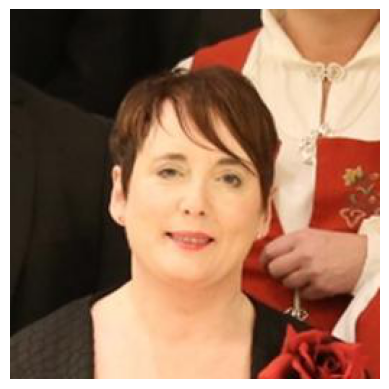

In [13]:
x,y = generator.next()

print(f"Predicted likelihood : {meso.predict(x)[0][0]:.4f}")
print(f"Actual label : {int(y[0])}")
print(f"\n Correct prediction : {round(meso.predict(x)[0][0]) == y[0]}")

#showing the Image
plt.imshow(np.squeeze(x))
plt.axis('off')

In [30]:
import gradio as gr
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np

# Load your pre-trained model
model = meso

def prepare_image(image, target_size):
    if image.mode != "RGB":
        image = image.convert("RGB")
    image = image.resize(target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return image

def predict(image):
    target_size = (256,256)  # Adjust based on your model's input size
    image = prepare_image(image, target_size)
    
    # Predict using the model
    preds = model.predict(image)
    label = int(preds[0][0] > 0.5)  # Assuming binary classification, threshold at 0.5
    
    # Convert to human-readable label
    label_name = 'Real' if label == 1 else 'Fake'
    
    return label_name

# Create Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Image Classification",
    description="Upload an image to determine if it is Fake or Real."
)

# Launch the interface
if __name__ == '__main__':
    interface.launch()


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


IMPORTANT: You are using gradio version 4.28.3, however version 4.29.0 is available, please upgrade.
--------
1/1 [==============================] - 0s 33ms/step


In [32]:
import gradio as gr
import cv2
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np

# Load your pre-trained model
model = meso

def prepare_image(image, target_size):
    if image.mode != "RGB":
        image = image.convert("RGB")
    image = image.resize(target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return image

def predict_frame(image):
    target_size = (256,256)  # Adjust based on your model's input size
    image = prepare_image(image, target_size)
    
    # Predict using the model
    preds = model.predict(image)
    label = int(preds[0][0] > 0.5)  # Assuming binary classification, threshold at 0.5
    
    return label

def predict_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
    
    labels = []
    
    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        if i % frame_rate == 0:  # Sample one frame per second
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(frame)
            label = predict_frame(pil_img)
            labels.append(label)
    
    cap.release()
    
    # Aggregate results (e.g., majority voting)
    if labels:
        final_label = int(np.mean(labels) > 0.5)
    else:
        final_label = 0  # Default to "Fake" if no frames processed
    
    return 'Real' if final_label == 1 else 'Fake'

# Create Gradio interface
interface = gr.Interface(
    fn=predict_video,
    inputs=gr.Video(),
    outputs="text",
    title="Video Classification",
    description="Upload a video to determine if it is Fake or Real."
)

# Launch the interface
if __name__ == '__main__':
    interface.launch()


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


IMPORTANT: You are using gradio version 4.28.3, however version 4.29.0 is available, please upgrade.
--------
1/1 [==============================] - 0s 43ms/step
